In [1]:
import numpy as np
import json
from tqdm import tqdm
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

### Loading correlations

In [3]:
instruments = ["vocal", "mridangam", "violin"]
correlations = {}

for artist in tqdm(os.listdir(dataset_path), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    correlations.setdefault(artist, {})

    for song in tqdm(os.listdir(artist_dir), desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        correlations[artist].setdefault(song, {})

        for instrument in instruments:
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.exists(instrument_dir):
                continue

            correlations[artist][song].setdefault(instrument, {})

            try:
                with open(
                    os.path.join(instrument_dir, "05_correlation_05s_windows.json"), "r"
                ) as f:
                    correlations[artist][song][instrument] = json.load(f)
            except FileNotFoundError:
                print(
                    f"File not found for {artist}/{song}/{instrument}. Skipping this instrument."
                )
                continue

Artists: 100%|██████████| 38/38 [00:02<00:00, 15.56it/s]


In [4]:
# Aggregate counts across all artists and songs
for artist in correlations.keys():
    for song in correlations[artist].keys():
        for instrument in correlations[artist][song].keys():
            for body_part in correlations[artist][song][instrument].keys():
                if instrument == "mridangam" and body_part in ["left_hand", "left_arm"]:
                    print(f"file  {artist}/{song}/{instrument}/{body_part}.")
                if instrument == "violin" and body_part in ["right_arm", "right_hand"]:
                    print(f"file  {artist}/{song}/{instrument}/{body_part}.")


file  Aditya Narayanan/Sarasaksha Palaya/mridangam/left_arm.
file  Aditya Narayanan/Sarasaksha Palaya/mridangam/left_hand.
file  Aditya Narayanan/Sarasaksha Palaya/violin/right_arm.
file  Aditya Narayanan/Sarasaksha Palaya/violin/right_hand.
file  Aditya Narayanan/Chittam Irangadhe/mridangam/left_arm.
file  Aditya Narayanan/Chittam Irangadhe/mridangam/left_hand.
file  Aditya Narayanan/Koluvamaragada/mridangam/left_arm.
file  Aditya Narayanan/Koluvamaragada/mridangam/left_hand.
file  Aditya Narayanan/Koluvamaragada/violin/right_arm.
file  Aditya Narayanan/Koluvamaragada/violin/right_hand.
file  Srividya Vadnamali/Raju Vedale/mridangam/left_arm.
file  Srividya Vadnamali/Raju Vedale/mridangam/left_hand.
file  Srividya Vadnamali/Raju Vedale/violin/right_arm.
file  Srividya Vadnamali/Raju Vedale/violin/right_hand.
file  Srividya Vadnamali/Thillana/mridangam/left_arm.
file  Srividya Vadnamali/Thillana/mridangam/left_hand.
file  Srividya Vadnamali/Thillana/violin/right_arm.
file  Srividya Vad

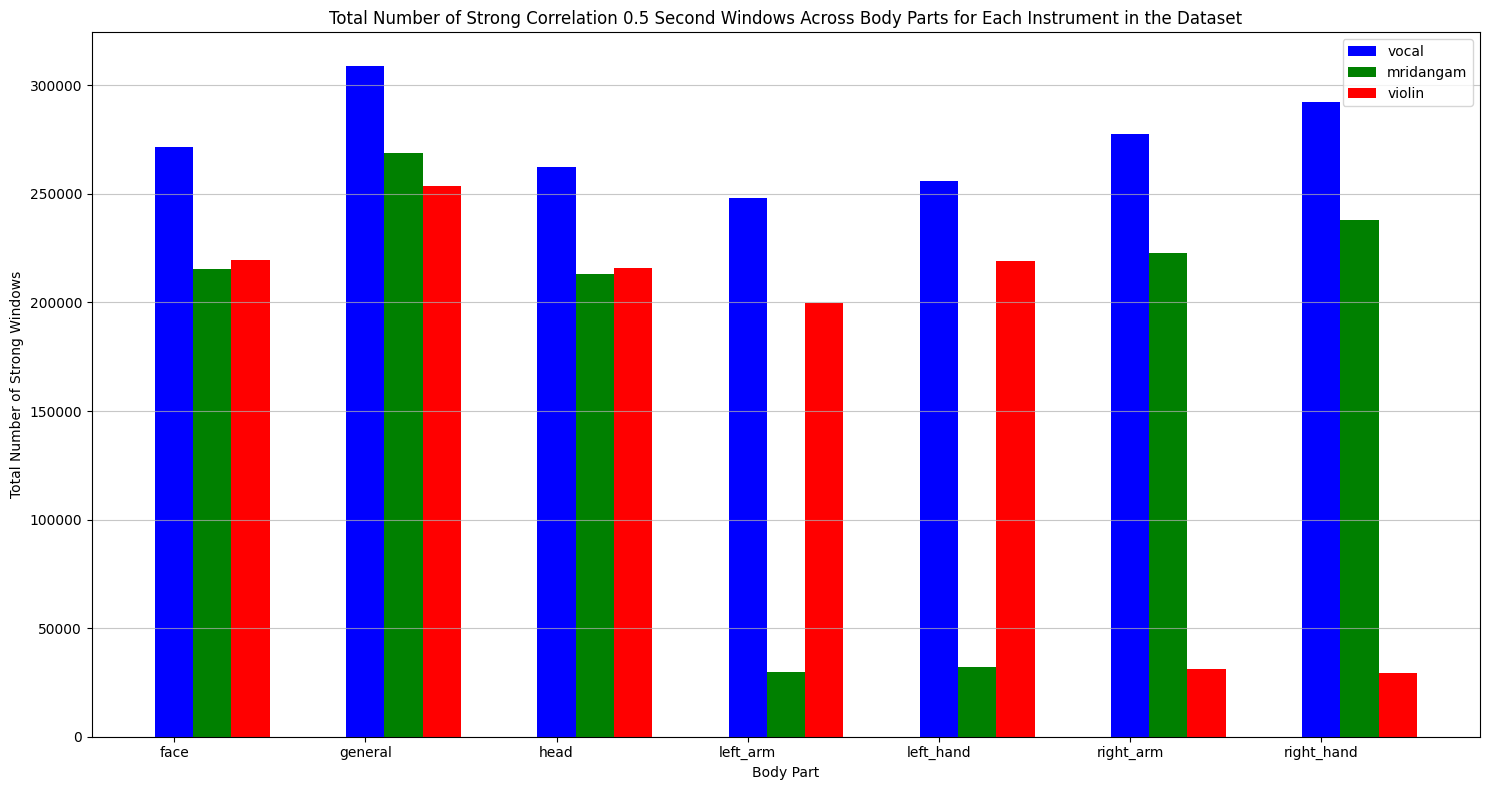

In [5]:
import matplotlib.pyplot as plt

body_parts_all = set()
body_part_counts = {instrument: {} for instrument in instruments}

# Aggregate counts across all artists and songs
for artist in correlations.keys():
    for song in correlations[artist].keys():
        for instrument in correlations[artist][song].keys():
            for body_part in correlations[artist][song][instrument].keys():
                speed_count = len(
                    correlations[artist][song][instrument][body_part][
                        "speed"
                    ]
                )
                accel_count = len(
                    correlations[artist][song][instrument][body_part][
                        "accel"
                    ]
                )
                total_count = speed_count + accel_count

                body_part_name = body_part
                body_parts_all.add(body_part_name)
                if body_part_name not in body_part_counts[instrument]:
                    body_part_counts[instrument][body_part_name] = 0
                body_part_counts[instrument][body_part_name] += total_count

# Prepare data for plotting
body_parts_list = sorted(list(body_parts_all))
num_body_parts = len(body_parts_list)
x = np.arange(num_body_parts)
width = 0.2  # Width of each bar

plt.figure(figsize=(15, 8))

colors = ["blue", "green", "red"]  # Colors for each instrument

for i, instrument in enumerate(instruments):
    counts = [
        body_part_counts[instrument].get(part, 0) for part in body_parts_list
    ]
    plt.bar(
        x + (i * width), counts, width=width, label=instrument, color=colors[i]
    )

plt.xlabel("Body Part")
plt.ylabel("Total Number of Strong Windows")
plt.title(
    "Total Number of Strong Correlation 0.5 Second Windows Across Body Parts for Each Instrument in the Dataset"
)
plt.xticks(x, body_parts_list)  # Set x-axis labels and rotate
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.grid(axis="y", alpha=0.7)
plt.legend()
plt.show()

### Cross-Correlation Study

In [25]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm

In [26]:
def normalize_window(data_window):
    """Normalize a window of data by subtracting mean and dividing by standard deviation."""
    return (data_window - np.mean(data_window)) / np.std(data_window)

In [27]:
def compute_cross_correlation(motion_window, audio_window, max_lag):
    """Compute cross-correlation between motion and audio windows."""
    # Normalize window data
    motion_norm = normalize_window(motion_window)
    audio_norm = normalize_window(audio_window)
    # Cross-correlation
    full_corr = correlate(motion_norm, audio_norm, mode="full")
    mid = len(full_corr) // 2
    return full_corr[mid - max_lag : mid + max_lag + 1]

In [28]:
def resample_to_30fps(data, original_fps):
    """Resample a 1D array to 30 fps using linear interpolation."""
    if original_fps == 30:
        return np.array(data)
    n_samples = len(data)
    duration = n_samples / original_fps
    t_original = np.linspace(0, duration, n_samples, endpoint=False)
    n_new = int(duration * 30)
    t_new = np.linspace(0, duration, n_new, endpoint=False)
    f = interp1d(t_original, data, kind='linear', fill_value="extrapolate")
    return f(t_new)

In [29]:
def process_feature_pair(motion_feature, audio_feature, instrument, feature_pair, 
                        window_size_frames, max_lag, all_correlations, original_fps):
    """Process a single feature pair for a recording, resampling to 30fps."""
    # Convert to numpy arrays and handle NaN values
    motion_array = np.array(motion_feature)
    audio_array = np.array(audio_feature)
    valid_indices = ~np.isnan(motion_array)
    motion = motion_array[valid_indices]
    audio = audio_array[valid_indices]

    # Resample to 30fps
    motion = resample_to_30fps(motion, original_fps)
    audio = resample_to_30fps(audio, original_fps)

    if len(motion) < window_size_frames:
        return  # Skip if not enough data for a window

    # Process in windows
    num_windows = len(motion) // window_size_frames
    for w in range(num_windows):
        start_idx = w * window_size_frames
        end_idx = start_idx + window_size_frames

        motion_window = motion[start_idx:end_idx]
        audio_window = audio[start_idx:end_idx]

        # Skip windows with little variation
        if np.std(motion_window) < 1e-6 or np.std(audio_window) < 1e-6:
            continue

        # Compute cross-correlation
        corr = compute_cross_correlation(motion_window, audio_window, max_lag)

        # Store correlation results by instrument and globally
        all_correlations[instrument][feature_pair].append(corr)
        all_correlations["global"][feature_pair].append(corr)

In [30]:
def process_recordings_30fps(motion_features, audio_features, dataset_metadata, 
                            feature_pairs, window_size_sec, instruments):
    """Process all recordings and compute windowed cross-correlations, enforcing 30fps."""
    all_correlations = {
        "global": {pair: [] for pair in feature_pairs},
        **{instr: {pair: [] for pair in feature_pairs} for instr in instruments}
    }
    lags = np.arange(-30, 31)  # For 1 second lag at 30fps

    for artist in tqdm(motion_features.keys(), desc="Processing artists"):
        for song in tqdm(motion_features[artist].keys(), desc="Processing songs", leave=False):
            original_fps = dataset_metadata[artist][song]["fps"]
            if original_fps is None:
                print(f"Missing FPS information for {artist}/{song}, skipping.")
                continue

            for instrument in motion_features[artist][song].keys():
                if instrument not in instruments:
                    continue

                for motion_type, audio_type in feature_pairs:
                    try:
                        motion_feature = motion_features[artist][song][instrument]["general"][motion_type]
                        audio_feature = audio_features[artist][song][instrument][audio_type]
                        process_feature_pair(
                            motion_feature, audio_feature, instrument,
                            (motion_type, audio_type), int(window_size_sec * 30), 30,
                            all_correlations, original_fps
                        )
                    except Exception as e:
                        print(f"Error processing {artist}/{song}/{instrument}/{motion_type}-{audio_type}: {e}")
                        break

    return all_correlations, lags

In [31]:
def plot_results(all_correlations, feature_pairs, lags, fps, instruments):
    """Plot cross-correlation results for each category and feature pair."""
    for category in ["global"] + instruments:
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Cross-correlation results for: {category.capitalize()}", fontsize=16)
        
        for i, pair in enumerate(feature_pairs, 1):
            if all_correlations[category][pair]:  # Check if we have data
                mean_corr = np.mean(all_correlations[category][pair], axis=0)
                std_corr = np.std(all_correlations[category][pair], axis=0)
                
                plt.subplot(2, 2, i)
                plt.plot(lags / fps, mean_corr, "b-", label="Mean")
                plt.fill_between(
                    lags / fps,
                    mean_corr - std_corr,
                    mean_corr + std_corr,
                    alpha=0.2,
                    color="b",
                    label="±1 std",
                )
                
                # Find and mark the maximum correlation
                max_idx = np.argmax(np.abs(mean_corr))
                max_corr = mean_corr[max_idx]
                max_lag_time = lags[max_idx] / fps
                
                plt.plot(max_lag_time, max_corr, "ro")
                plt.text(
                    max_lag_time,
                    max_corr,
                    f"\nlag: {max_lag_time:.2f}s\ncorr: {max_corr:.2f}",
                    verticalalignment="bottom",
                )
                
                plt.xlabel("Lag (s)")
                plt.ylabel("Cross-correlation")
                plt.title(f"{pair[0]} vs {pair[1]}")
                plt.grid(True)
                plt.legend()
            else:
                plt.subplot(2, 2, i)
                plt.text(0.5, 0.5, "No data available", 
                        horizontalalignment='center', verticalalignment='center')
                plt.title(f"{pair[0]} vs {pair[1]}")
                
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Make room for suptitle
        plt.show()

In [32]:
def print_summary(all_correlations, feature_pairs, lags, fps, instruments):
    """Print summary statistics of optimal lags for each category and feature pair."""
    print("Summary of optimal lags (in seconds):")
    print("=====================================")
    for category in ["global"] + instruments:
        print(f"\n{category.capitalize()}:")
        for pair in feature_pairs:
            if all_correlations[category][pair]:
                mean_corr = np.mean(all_correlations[category][pair], axis=0)
                max_idx = np.argmax(np.abs(mean_corr))
                max_corr = mean_corr[max_idx]
                max_lag_time = lags[max_idx] / fps
                print(f"  {pair[0]} vs {pair[1]}: lag = {max_lag_time:.3f}s, corr = {max_corr:.3f}")
            else:
                print(f"  {pair[0]} vs {pair[1]}: No data")

In [23]:
instruments = ["vocal", "mridangam", "violin"]
motion_features = {}
audio_features = {}

for artist in tqdm(os.listdir(dataset_path), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(os.listdir(artist_dir), desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        for instrument in instruments:
            instrument_dir = os.path.join(song_dir, instrument)
            if not os.path.exists(instrument_dir):
                continue

            motion_features[artist][song].setdefault(instrument, {})
            audio_features[artist][song].setdefault(instrument, {})

            try:
                with open(
                    os.path.join(instrument_dir, "motion_features.json"), "r"
                ) as f:
                    motion_features[artist][song][instrument] = json.load(f)
                with open(
                    os.path.join(instrument_dir, "audio_features.json"), "r"
                ) as f:
                    audio_features[artist][song][instrument] = json.load(f)
            except FileNotFoundError:
                print(
                    f"File not found for {artist}/{song}/{instrument}. Skipping this instrument."
                )
                continue

Artists: 100%|██████████| 38/38 [00:27<00:00,  1.40it/s]


In [ ]:
feature_pairs = [
    ("mean_speed", "onset_env"),
    ("mean_speed", "rms"),
    ("mean_acceleration", "onset_env"),
    ("mean_acceleration", "rms"),
]
window_size_sec = 5
instruments = ["vocal", "mridangam", "violin"]

# Process all recordings
all_correlations, lags = process_recordings_30fps(
    motion_features, audio_features, dataset_metadata,
    feature_pairs, window_size_sec, instruments
)

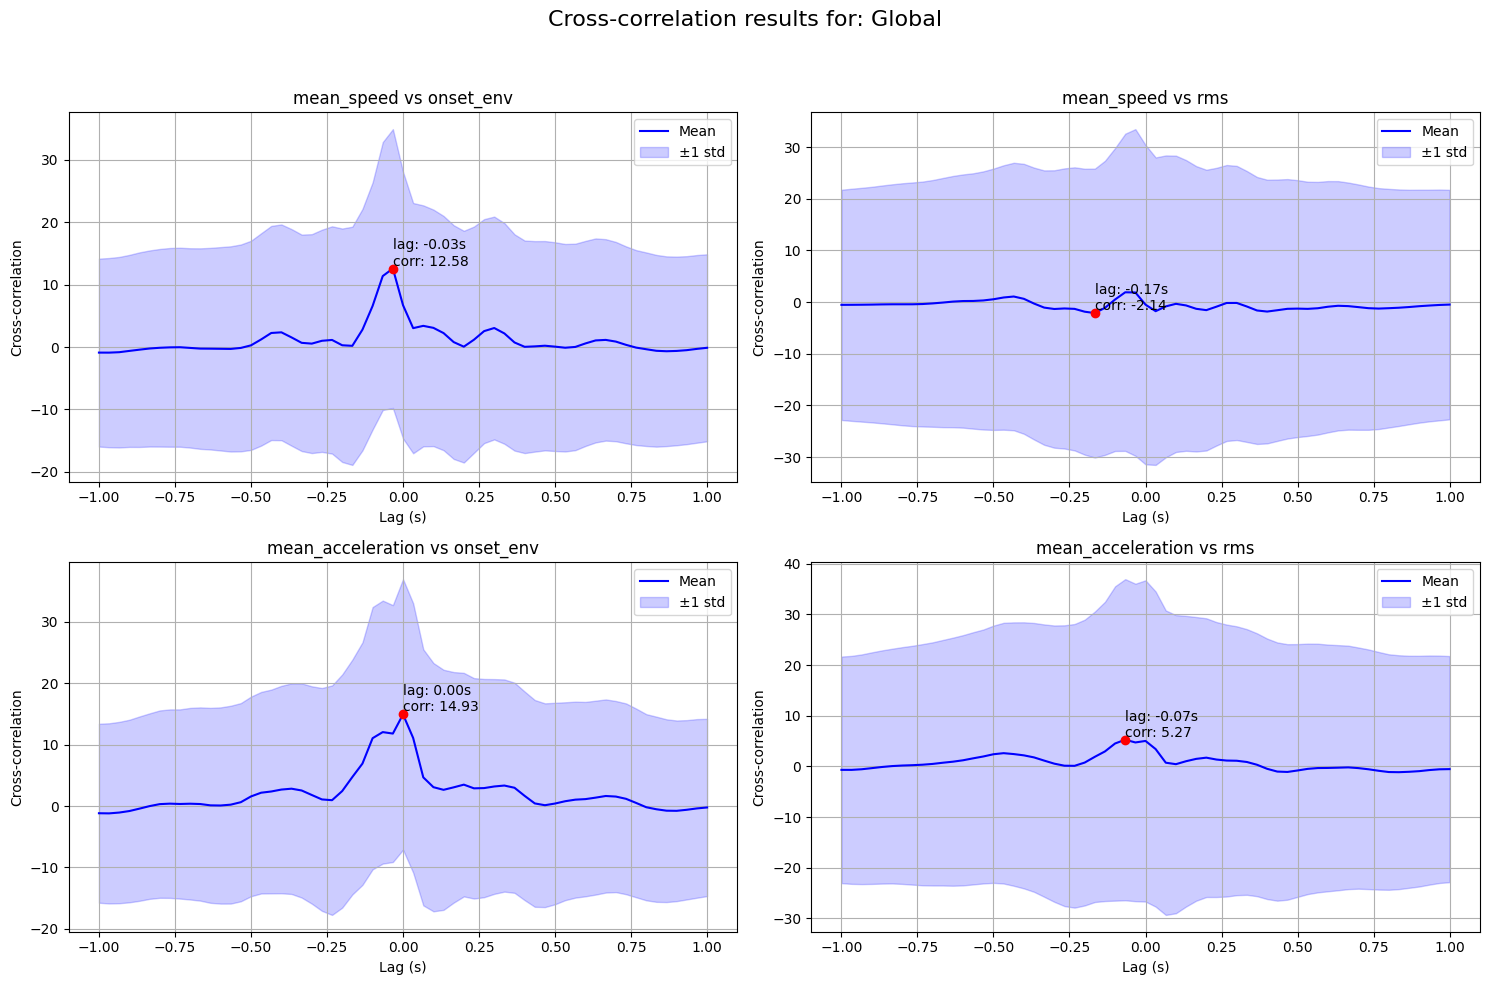

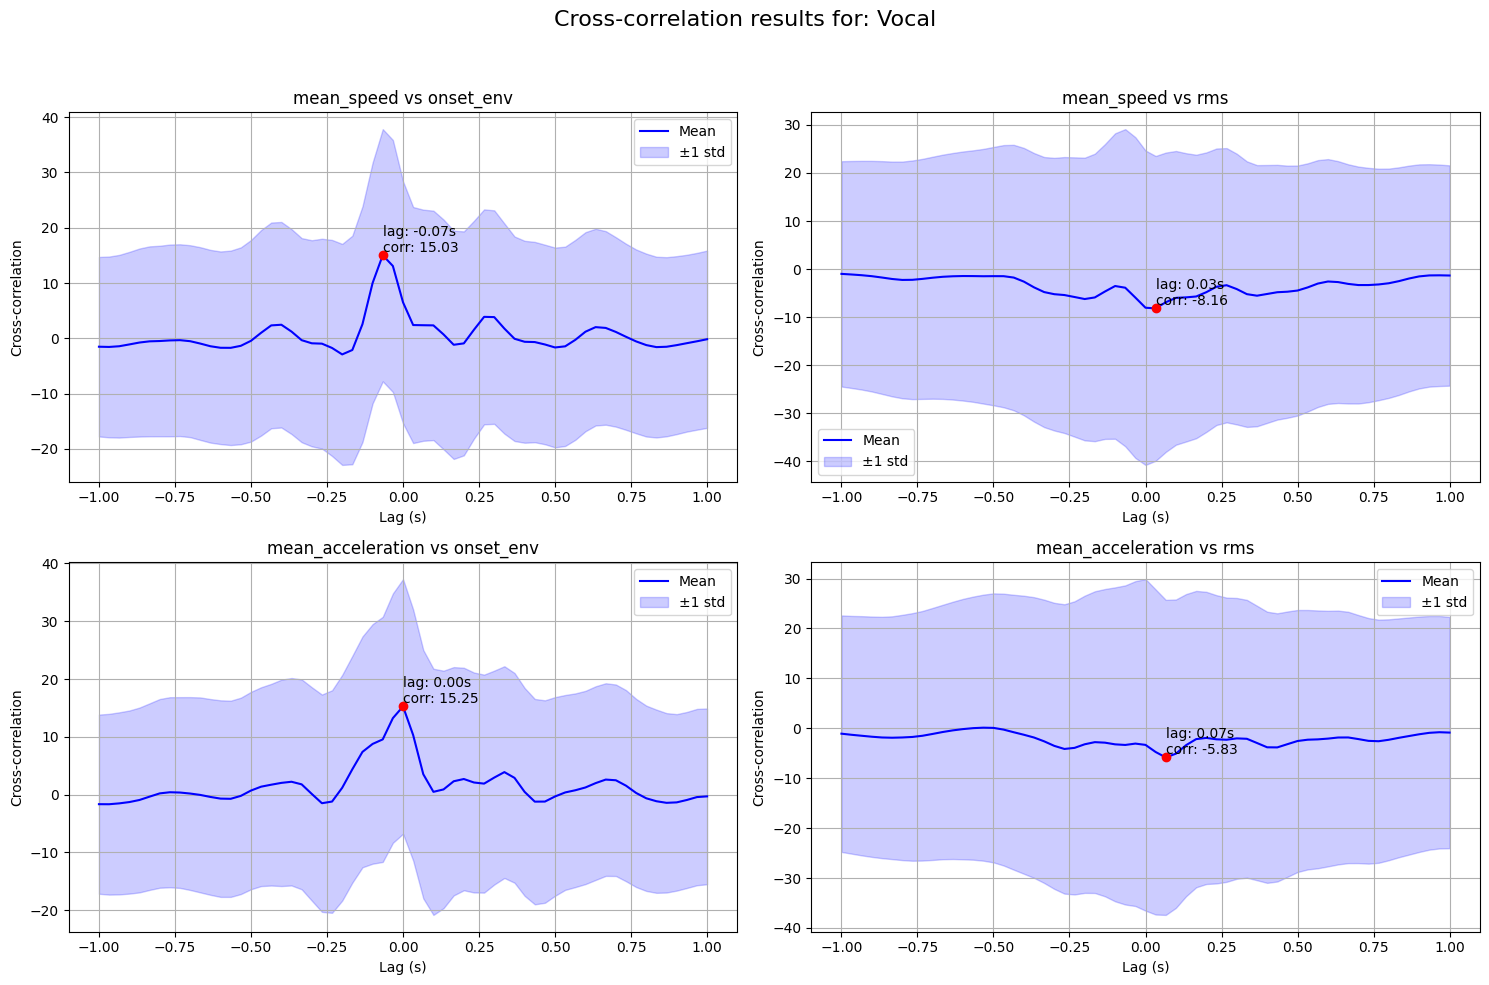

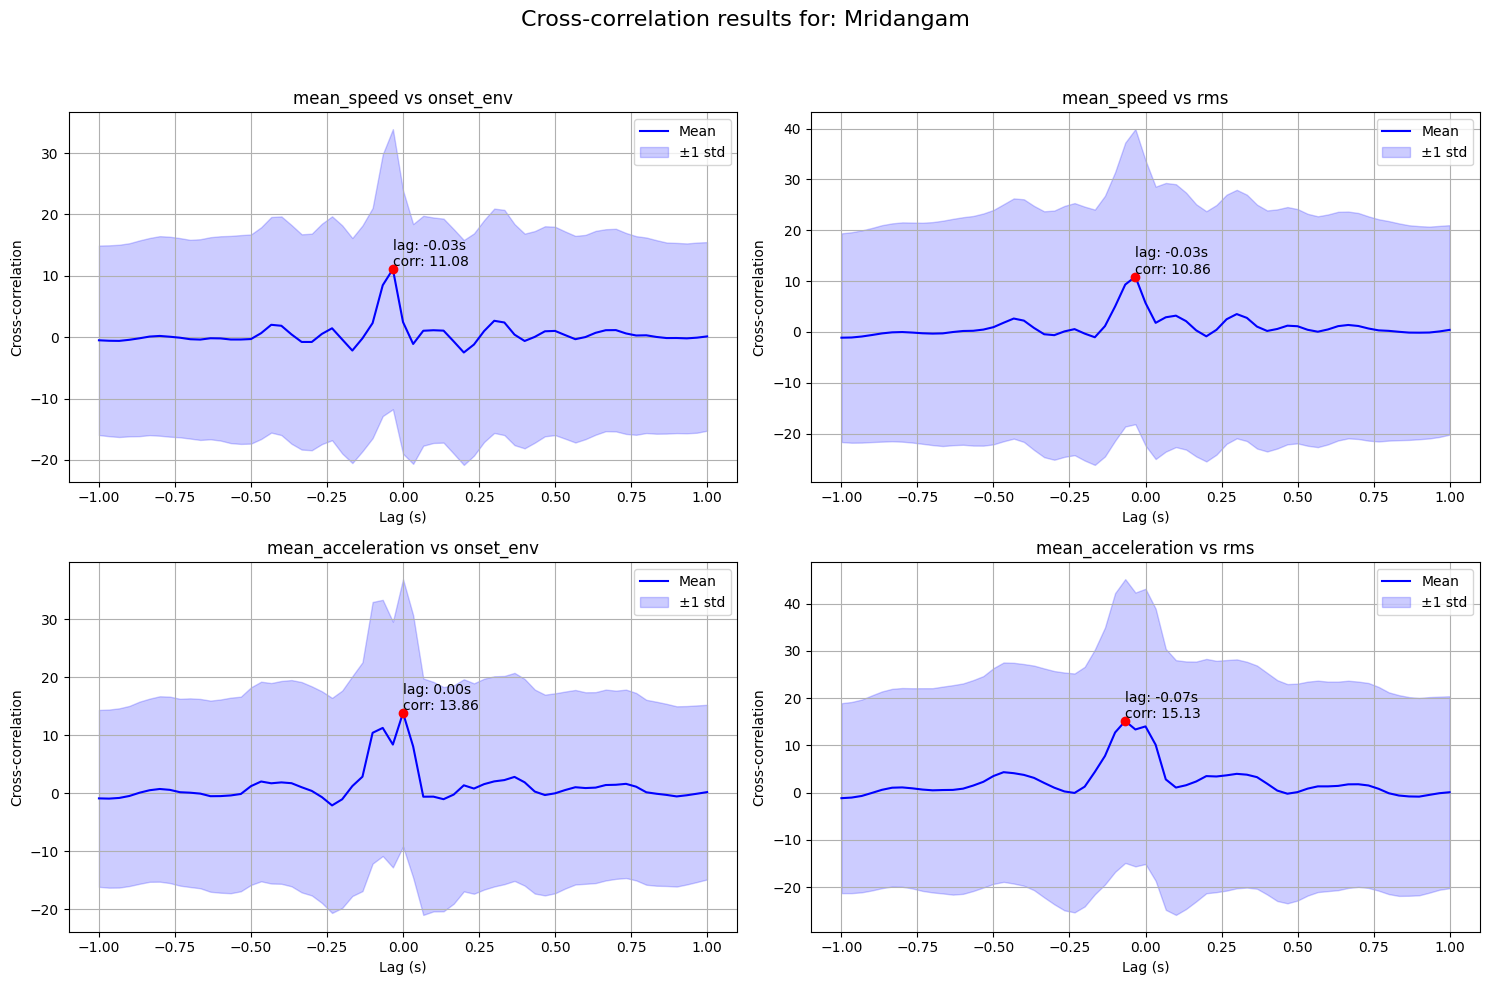

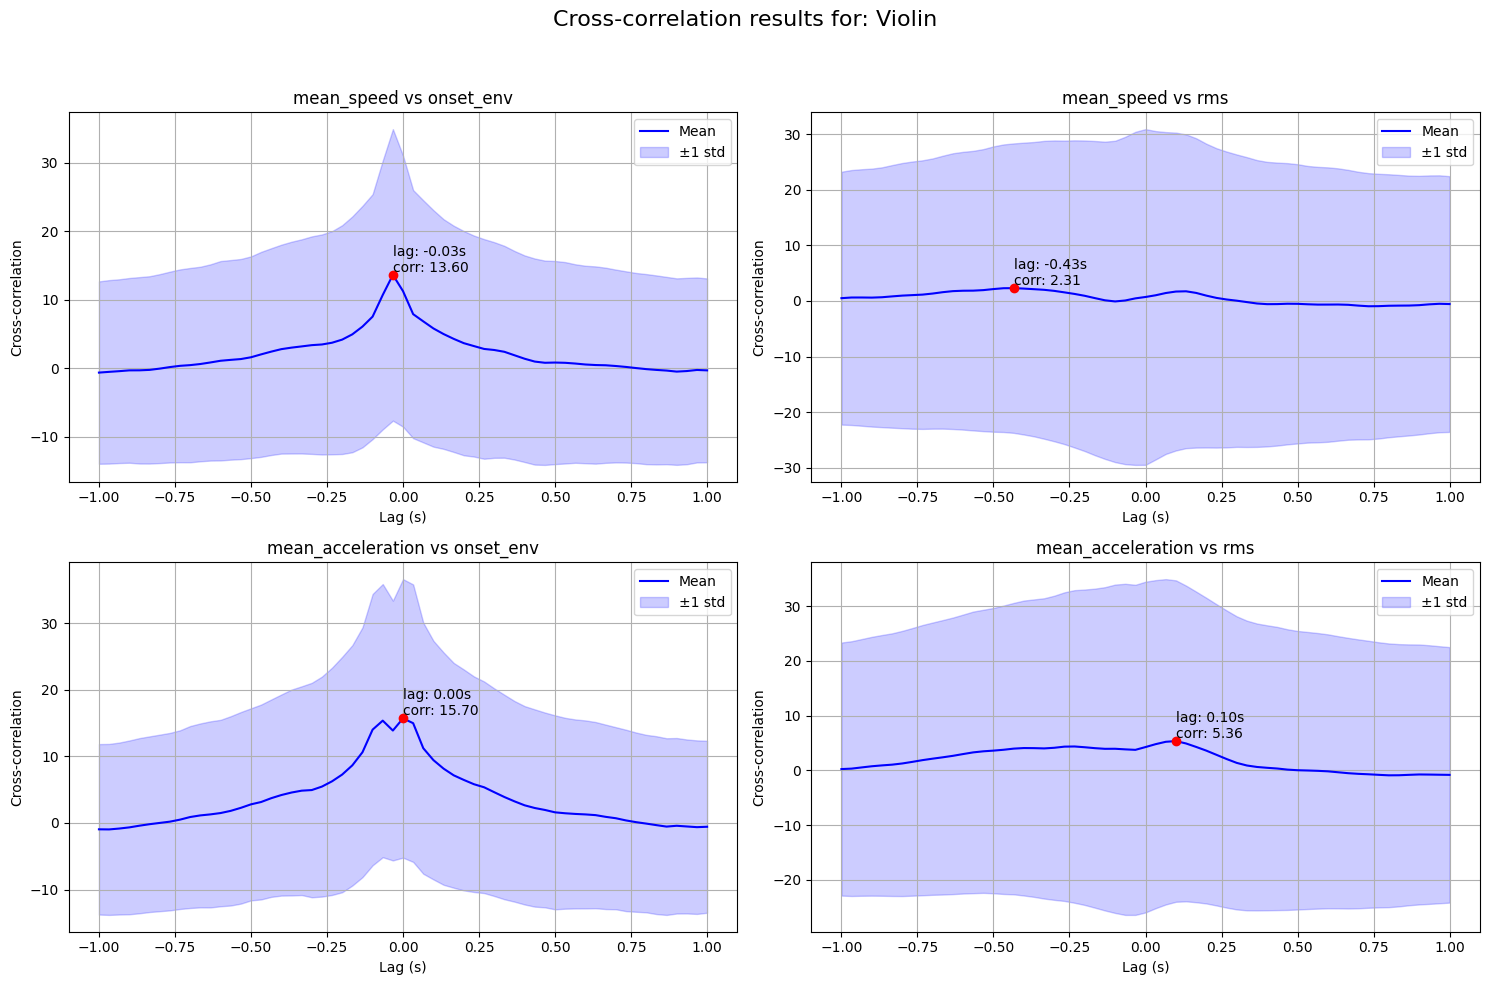

Summary of optimal lags (in seconds):

Global:
  mean_speed vs onset_env: lag = -0.033s, corr = 12.578
  mean_speed vs rms: lag = -0.167s, corr = -2.136
  mean_acceleration vs onset_env: lag = 0.000s, corr = 14.932
  mean_acceleration vs rms: lag = -0.067s, corr = 5.269

Vocal:
  mean_speed vs onset_env: lag = -0.067s, corr = 15.025
  mean_speed vs rms: lag = 0.033s, corr = -8.163
  mean_acceleration vs onset_env: lag = 0.000s, corr = 15.249
  mean_acceleration vs rms: lag = 0.067s, corr = -5.830

Mridangam:
  mean_speed vs onset_env: lag = -0.033s, corr = 11.080
  mean_speed vs rms: lag = -0.033s, corr = 10.864
  mean_acceleration vs onset_env: lag = 0.000s, corr = 13.861
  mean_acceleration vs rms: lag = -0.067s, corr = 15.131

Violin:
  mean_speed vs onset_env: lag = -0.033s, corr = 13.601
  mean_speed vs rms: lag = -0.433s, corr = 2.313
  mean_acceleration vs onset_env: lag = 0.000s, corr = 15.705
  mean_acceleration vs rms: lag = 0.100s, corr = 5.362


In [34]:
plot_results(all_correlations, feature_pairs, lags, 30, instruments)
print_summary(all_correlations, feature_pairs, lags, 30, instruments)